In [1]:
import os
import sys
from datetime import date
from tme_utils import (
    EventTypes,
    get_client,
    query_blocks,
    query_events,
    query_receipt,
    query_state
)

%load_ext google.cloud.bigquery
from google.cloud import bigquery

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 5]

In [2]:
project = "celo-testnet"
dataset = "tme_test_stakeoff"
partition = "*"
table = "tme_stakeoff_test_{0}".format(partition)
# dataset = "transaction_metrics_exporter"
# partition = date.today().strftime("%Y%m%d")
# table = "transaction_metrics_exporter_{0}".format(partition)

window_min = 130500
window_max = 131000

client = get_client(project)

tme = client.get_dataset(dataset)
table_path = ".".join([project, dataset, table])
print(table_path)

celo-testnet.tme_test_stakeoff.tme_stakeoff_test_*


In [3]:
df_blocks = query_blocks(client, table_path, window_min, window_max)
df_receipt = query_receipt(client, table_path, window_min, window_max)
df_state = query_state(client, table_path, window_min, window_max, df_blocks)
df_events = query_events(client, table_path, window_min, window_max, df_state)
df_blocks.describe()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount,blocktime
count,5.010000e+02,501.000000,501.000000,501.0,501.000000,500.0
mean,1.579356e+09,130750.000000,140163.526946,20000000.0,1.393214,5.0
std,7.238525e+02,144.770508,83674.758231,0.0,0.599228,0.0
min,1.579355e+09,130500.000000,0.000000,20000000.0,1.000000,5.0
25%,1.579355e+09,130625.000000,82138.000000,20000000.0,1.000000,5.0
50%,1.579356e+09,130750.000000,123207.000000,20000000.0,1.000000,5.0
75%,1.579356e+09,130875.000000,182138.000000,20000000.0,2.000000,5.0
max,1.579357e+09,131000.000000,539225.000000,20000000.0,5.000000,5.0


In [4]:
query_balance = f"""
SELECT 
    jsonPayload.blockNumber,
    jsonPayload.values.balance,
    jsonPayload.contract,
    jsonPayload.function,
    jsonPayload.args
FROM `celo-testnet.tme_test_stakeoff.transaction_metrics_exporter_20200401` 
WHERE 
    jsonPayload.function="balanceOf" and
    jsonPayload.event='{EventTypes.RECEIVED_STATE.value}' and
    jsonPayload.blockNumber >= {window_min} and
    jsonPayload.blockNumber <= {window_max}
ORDER BY 
    jsonPayload.blockNumber DESC
"""

df_balance = client.query(
    query_balance,
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()


In [5]:
df_balance.head()

,blockNumber,balance,contract,function,args
0,131000.0,9.985538e+25,GoldToken,balanceOf,None
1,131000.0,0.000000e+00,StableToken,balanceOf,"[""0x1726428A6D575FdC9C7C3B7bac9f2247a5649Bf2""]"
2,130999.0,9.985538e+25,GoldToken,balanceOf,None
3,130999.0,0.000000e+00,StableToken,balanceOf,"[""0x1726428A6D575FdC9C7C3B7bac9f2247a5649Bf2""]"
4,130998.0,0.000000e+00,StableToken,balanceOf,"[""0x1726428A6D575FdC9C7C3B7bac9f2247a5649Bf2""]"


In [6]:
df_blocks.head()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount,blocktime
0,1.579357e+09,131000.0,132138.0,20000000.0,4,5.0
1,1.579357e+09,130999.0,161501.0,20000000.0,1,5.0
2,1.579357e+09,130998.0,79363.0,20000000.0,1,5.0
3,1.579357e+09,130997.0,120432.0,20000000.0,1,5.0
4,1.579357e+09,130996.0,199795.0,20000000.0,1,5.0


last block  : 131000 on 1579357105.0
first block : 130500 on 1579354605.0
blocks load : 501
transactions: 698
mean gasUsed: 140164 GcWei
mean blocktime: 5.0 s


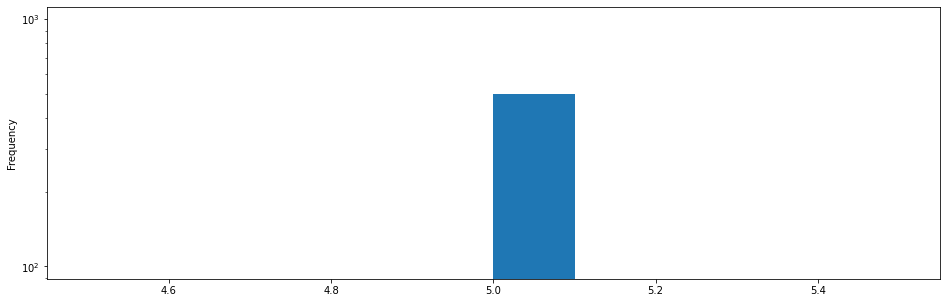

In [7]:
last_block, first_block = df_blocks.blockNumber.max(), df_blocks.blockNumber.min()
print(f"last block  : {last_block:.0f} on {df_blocks.timestamp.max()}") 
print(f"first block : {first_block:.0f} on {df_blocks.timestamp.min()}")
print(f"blocks load : {df_blocks.timestamp.count():.0f}")
print(f"transactions: {df_blocks.txAmount.sum()}")
print(f"mean gasUsed: {df_blocks.gasUsed.mean():.0f} GcWei")
df_blocks.blocktime.plot.hist(logy=True)
print(f"mean blocktime: {df_blocks.blocktime.mean():.1f} s")

In [8]:
df_state.describe()

,blockNumber,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime
count,501.000000,5.010000e+02,5.010000e+02,501.000,5.010000e+02,5.010000e+02,5.010000e+02,5.010000e+02,501.000000,501.0,501.000000,500.0
mean,130750.000000,6.002782e+26,1.614589e+24,0.999,9.983483e+23,9.978718e+23,1.089266e+26,1.579356e+09,140163.526946,20000000.0,1.393214,5.0
std,144.770508,3.060428e+20,8.533734e+17,0.000,7.392148e+20,7.589632e+20,3.439408e+10,7.238525e+02,83674.758231,0.0,0.599228,0.0
min,130500.000000,6.002777e+26,1.614587e+24,0.999,9.975553e+23,9.965857e+23,1.089266e+26,1.579355e+09,0.000000,20000000.0,1.000000,5.0
25%,130625.000000,6.002779e+26,1.614588e+24,0.999,9.976287e+23,9.975886e+23,1.089266e+26,1.579355e+09,82138.000000,20000000.0,1.000000,5.0
50%,130750.000000,6.002782e+26,1.614589e+24,0.999,9.985751e+23,9.976185e+23,1.089266e+26,1.579356e+09,123207.000000,20000000.0,1.000000,5.0
75%,130875.000000,6.002785e+26,1.614590e+24,0.999,9.986149e+23,9.985836e+23,1.089266e+26,1.579356e+09,182138.000000,20000000.0,2.000000,5.0
max,131000.000000,6.002787e+26,1.614590e+24,0.999,9.996049e+23,9.986274e+23,1.089266e+26,1.579357e+09,539225.000000,20000000.0,5.000000,5.0


In [9]:
df_state.tail()

,blockNumber,timestamp_tme,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime,datetime_block
496,130996.0,2020-03-26 08:33:31.558425+00:00,6.002787e+26,1.614590e+24,0.999,9.995751e+23,9.965857e+23,1.089266e+26,1.579357e+09,199795.0,20000000.0,1,5.0,2020-01-18 14:18:05
497,130997.0,2020-03-26 08:33:32.313145+00:00,6.002787e+26,1.614590e+24,0.999,9.975553e+23,9.985538e+23,1.089266e+26,1.579357e+09,120432.0,20000000.0,1,5.0,2020-01-18 14:18:10
498,130998.0,2020-03-26 08:33:32.912632+00:00,6.002787e+26,1.614590e+24,0.999,9.975553e+23,9.985538e+23,1.089266e+26,1.579357e+09,79363.0,20000000.0,1,5.0,2020-01-18 14:18:15
499,130999.0,2020-03-26 08:33:33.368445+00:00,6.002787e+26,1.614590e+24,0.999,9.975553e+23,9.985538e+23,1.089266e+26,1.579357e+09,161501.0,20000000.0,1,5.0,2020-01-18 14:18:20
500,131000.0,2020-03-26 08:33:34.120118+00:00,6.002787e+26,1.614590e+24,0.999,9.975553e+23,9.985538e+23,1.089266e+26,1.579357e+09,132138.0,20000000.0,4,5.0,2020-01-18 14:18:25


Text(0, 0.5, 'SortedOracles.medianRate')

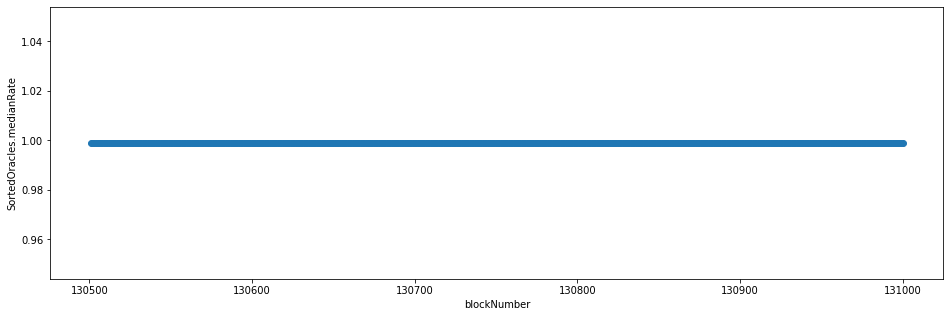

In [10]:
df_slice = df_state[1:]
df_sortedOracles = df_slice.set_index('blockNumber')['medianRate']
ax = df_sortedOracles.plot(marker='o')
ax.set_ylabel("SortedOracles.medianRate")

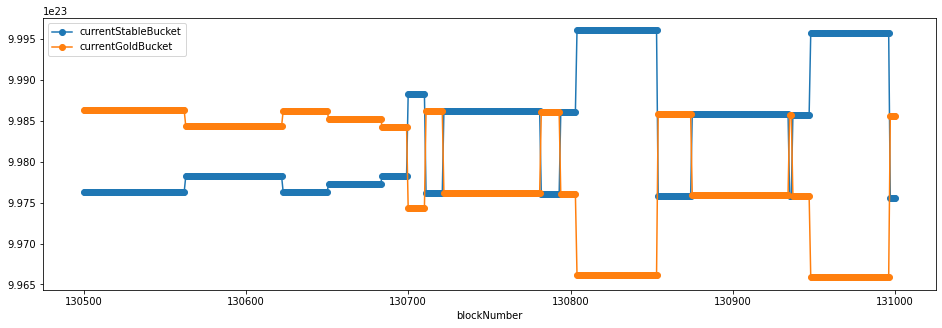

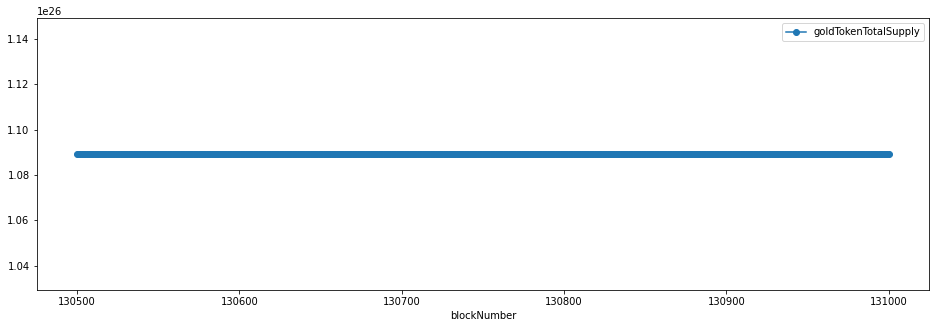

In [11]:
df_stableToken = df_state.set_index('blockNumber')[['currentStableBucket']]
ax = df_stableToken.plot(marker='o')
# df_stableToken[df_stableToken<2e24].plot(marker='o')
df_goldbucket = df_state.set_index('blockNumber')[['currentGoldBucket']]
df_goldbucket.plot(marker='o', ax=ax)
df_goldToken = df_state.set_index('blockNumber')[['goldTokenTotalSupply']]
df_goldToken.plot(marker='o')

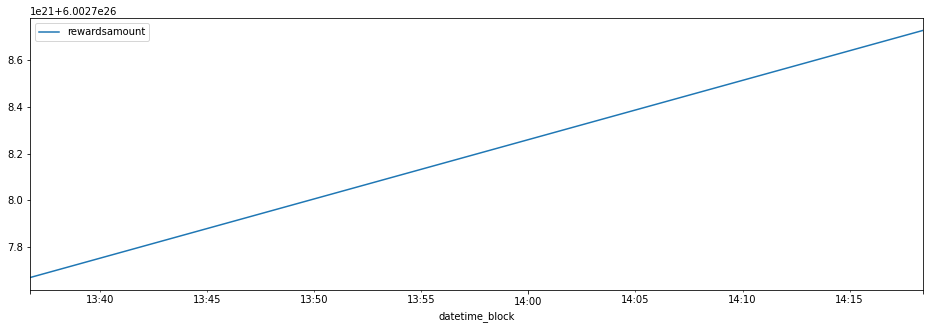

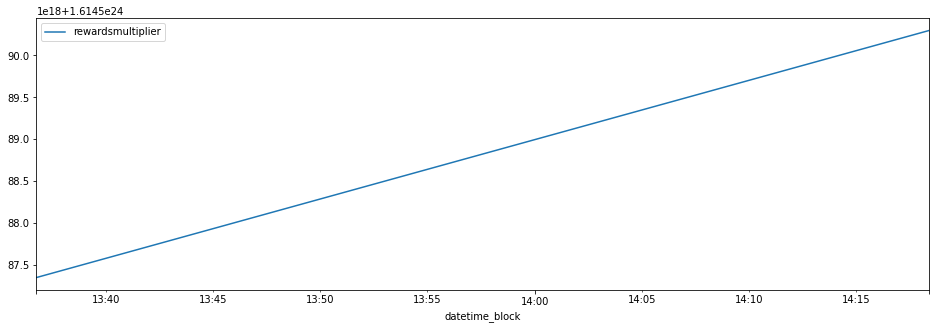

In [12]:
df_rewardsAmount = df_state.set_index('datetime_block')[['rewardsamount']]
ax = df_rewardsAmount.plot()
df_rewardsMultiplier = df_state.set_index('datetime_block')[['rewardsmultiplier']]
ax = df_rewardsMultiplier.plot()

In [13]:
df_events.describe()

,blockNumber,sellamount,buyamount,rewardsamount,rewardsmultiplier,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime
count,1594.000000,2.100000e+01,2.100000e+01,1.594000e+03,1.594000e+03,1.594000e+03,1.594000e+03,1.594000e+03,1.594000e+03,1.594000e+03,1594.000000,1594.0,1594.000000,1586.0
mean,130761.478043,6.855900e+20,6.818012e+20,6.002782e+26,1.614589e+24,9.990000e-01,9.984284e+23,9.977908e+23,1.089266e+26,1.579356e+09,172403.385194,20000000.0,1.701380,5.0
std,128.760589,4.576164e+20,4.550390e+20,2.721981e+20,7.590003e+17,1.110571e-16,7.267187e+20,7.388080e+20,0.000000e+00,6.438029e+02,92623.133771,0.0,0.871483,0.0
min,130500.000000,0.000000e+00,0.000000e+00,6.002777e+26,1.614587e+24,9.990000e-01,9.975553e+23,9.965857e+23,1.089266e+26,1.579355e+09,29363.000000,20000000.0,1.000000,5.0
25%,130674.000000,1.000000e+20,9.958967e+19,6.002780e+26,1.614588e+24,9.990000e-01,9.976287e+23,9.975787e+23,1.089266e+26,1.579355e+09,111501.000000,20000000.0,1.000000,5.0
50%,130771.500000,1.000000e+21,9.946060e+20,6.002782e+26,1.614589e+24,9.990000e-01,9.985851e+23,9.976185e+23,1.089266e+26,1.579356e+09,160780.000000,20000000.0,2.000000,5.0
75%,130860.000000,1.000000e+21,9.950036e+20,6.002784e+26,1.614589e+24,9.990000e-01,9.986149e+23,9.985538e+23,1.089266e+26,1.579356e+09,211501.000000,20000000.0,2.000000,5.0
max,131000.000000,1.000000e+21,9.950036e+20,6.002787e+26,1.614590e+24,9.990000e-01,9.996049e+23,9.986274e+23,1.089266e+26,1.579357e+09,539225.000000,20000000.0,5.000000,5.0


In [14]:
df_events.head()

,blockNumber,address,eventName,identifier,addr,identifierhash,slasheridentifier,account,metadataurl,value,...,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply,timestamp_block,gasUsed,gasLimit,txAmount,blocktime,datetime_block
0,131000.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,10000,...,0.999,9.975553e+23,9.985538e+23,1.089266e+26,1.579357e+09,132138.0,20000000.0,4,5.0,2020-01-18 14:18:25
1,131000.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,10000,...,0.999,9.975553e+23,9.985538e+23,1.089266e+26,1.579357e+09,132138.0,20000000.0,4,5.0,2020-01-18 14:18:25
2,131000.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,10000,...,0.999,9.975553e+23,9.985538e+23,1.089266e+26,1.579357e+09,132138.0,20000000.0,4,5.0,2020-01-18 14:18:25
3,131000.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,10000,...,0.999,9.975553e+23,9.985538e+23,1.089266e+26,1.579357e+09,132138.0,20000000.0,4,5.0,2020-01-18 14:18:25
4,131000.0,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,Transfer,None,None,None,None,None,None,10000,...,0.999,9.975553e+23,9.985538e+23,1.089266e+26,1.579357e+09,132138.0,20000000.0,4,5.0,2020-01-18 14:18:25


In [15]:
df_events.groupby('eventName').eventName.count().sort_values(ascending=False)

eventName
Transfer                     1500
Approval                       62
Exchanged                      21
AttestationsRequested           4
AttestationIssuerSelected       4
AttestationCompleted            3
Name: eventName, dtype: int64

In [16]:
df_exchange = df_events[df_events.eventName == "Exchanged"].set_index('blockNumber')[['exchanger', 'buyamount', 'sellamount', 'soldgold']]
df_exchange.groupby('exchanger').exchanger.count().sort_values(ascending=False)

exchanger
0x8fb800b94D2b1258236E598FCd5e65eAf45CA671    16
0xd6F05649c5350c20030de1dC57eD31510141F487     2
0x73b49DA41223585a650712363BA7878Ed60a964d     2
0x060b52F506579625aD73b99f1bE8D6B06259953D     1
Name: exchanger, dtype: int64

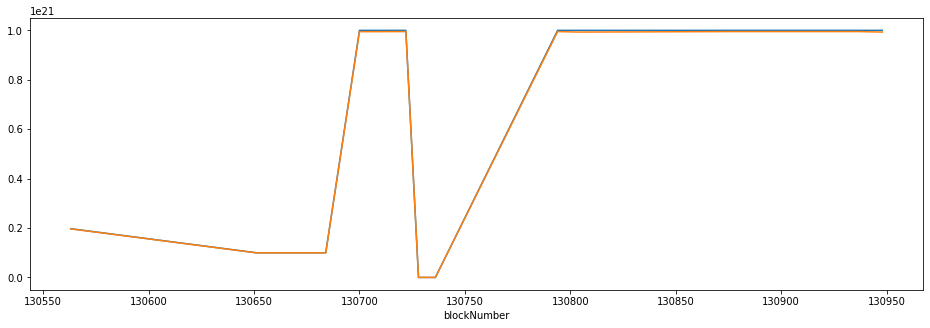

In [17]:
(df_exchange['sellamount']).plot()
(df_exchange['buyamount']).plot()

exchanger     0
buyamount     0
sellamount    0
soldgold      0
dtype: int64


exchanger     21
buyamount     21
sellamount    21
soldgold      21
dtype: int64

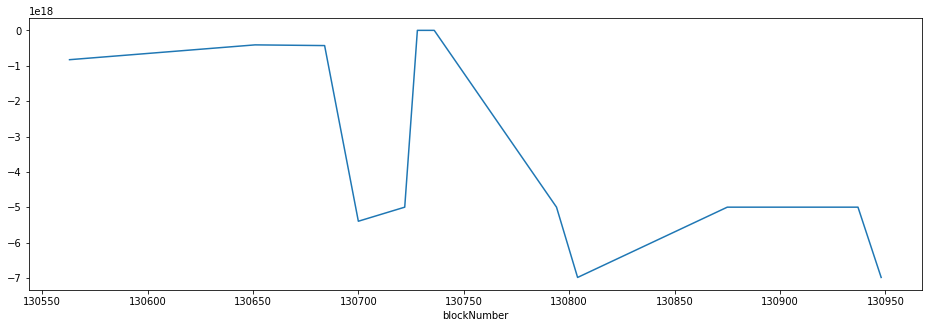

In [18]:
# difference
(df_exchange['buyamount']-df_exchange['sellamount']).plot()
print(df_exchange[df_exchange.soldgold].count())
df_exchange[df_exchange.soldgold == False].count()


In [19]:
df_ex = df_events.set_index('blockNumber')[['buyamount', 'sellamount', 'currentStableBucket', 'currentGoldBucket', 'soldgold']]
df_ex = df_ex[df_ex.buyamount.notna()]

Text(0, 0.5, 'currentGoldBucket')

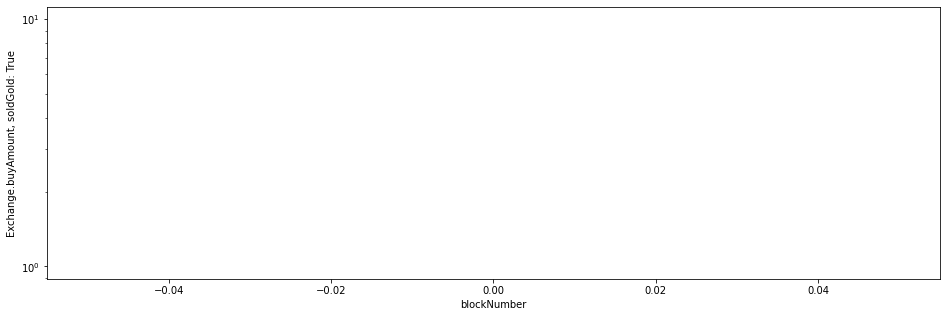

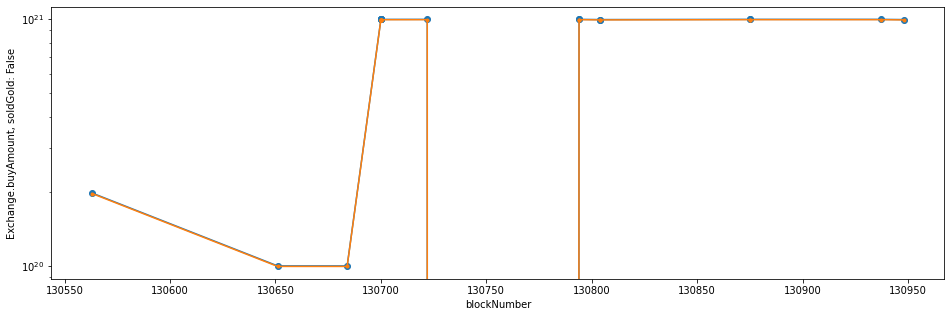

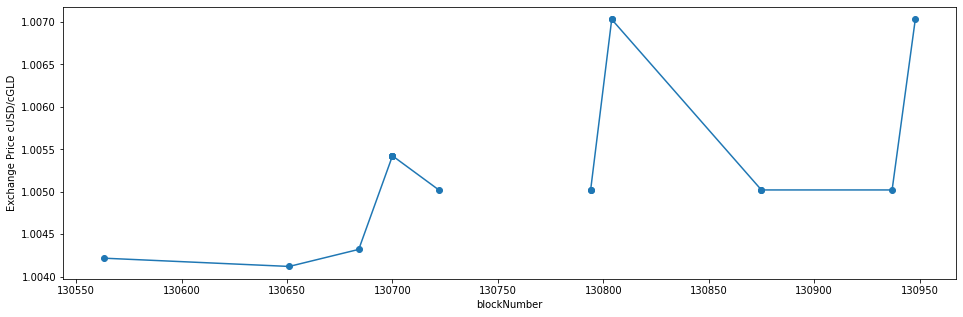

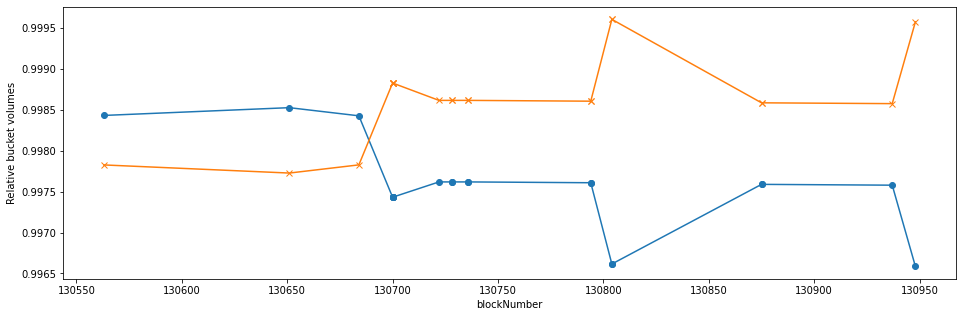

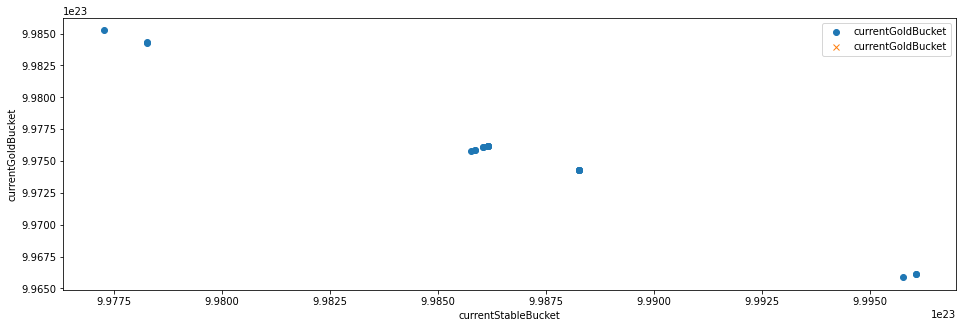

In [20]:
def estimate_buyamount(soldGold):
    df_buy = df_ex[df_ex.soldgold == soldGold]
    Ab = df_buy.buyamount
    As = df_buy.sellamount
    Bs = df_buy.currentStableBucket
    Bg = df_buy.currentGoldBucket
    Bbuy = Bs if soldGold else Bg
    Bsell = Bg if soldGold else Bs

    # buyamount computation is
    # Asell = (1-spread)*As
    # Abuy = Asell/(Bsell+Asell)*Bbuy
    spread = 0
    Asell = (1-spread)*As
    Abuy_hat = Asell/(Bsell+Asell)*Bbuy
    # Abuy_hat = Asell/(Bsell)*Bbuy
    
    return df_buy, Abuy_hat, Bbuy, Bsell


soldGold = True
df_buy_sellgold, Abuy_hat_sellgold, Bbuy_sellgold, Bsell_sellgold = estimate_buyamount(soldGold)
ax = Abuy_hat_sellgold.plot(marker='o')
ax.set_ylabel(f"Exchange.buyAmount, soldGold: {soldGold}")
df_buy_sellgold.buyamount.plot(marker='.')
(df_buy_sellgold.buyamount - Abuy_hat_sellgold).plot(marker='x', logy=True)

soldGold = False
df_buy_sellusd, Abuy_hat_sellusd, Bbuy_sellusd, Bsell_sellusd = estimate_buyamount(False)
plt.figure()
ax = Abuy_hat_sellusd.plot(marker='o')
ax.set_ylabel(f"Exchange.buyAmount, soldGold: {soldGold}")
df_buy_sellusd.buyamount.plot(marker='.')
(df_buy_sellusd.buyamount - Abuy_hat_sellusd).plot(marker='x', logy=True)

plt.figure()
ax = (df_buy_sellusd.sellamount/df_buy_sellusd.buyamount).plot(marker='o')
(df_buy_sellgold.buyamount/df_buy_sellgold.sellamount).plot(marker='x')
ax.set_ylabel(f"Exchange Price cUSD/cGLD")

plt.figure()
ax = (df_buy_sellusd.currentGoldBucket/1e24).plot(marker='o')
(df_buy_sellusd.currentStableBucket/1e24).plot(marker='x')
ax.set_ylabel(f"Relative bucket volumes")

fig, ax = plt.subplots(1, 1)
df_buy_sellusd.plot(x='currentStableBucket', y='currentGoldBucket', style='o', ax=ax)
df_buy_sellgold.plot(x='currentStableBucket', y='currentGoldBucket', style='x', ax=ax)
ax.set_ylabel(f"currentGoldBucket")

In [21]:
df_goldlocked = df_events[df_events.eventName == "GoldLocked"].set_index('blockNumber')[['account', 'value']]
df_goldlocked[['value']] = df_goldlocked[['value']].astype('float')
df_goldlocked.groupby('account').value.sum().sort_values(ascending=False)
df_goldlocked[df_goldlocked.account == "0x775a5C899Fd4A7CDD54e9f41738087748CfcB953"].groupby('account').value.sum().sort_values(ascending=False)

Series([], Name: value, dtype: float64)

In [22]:
df_receipt.head()

,blockNumber,from,address,topic
0,131000.0,0x8b7852da535df3d06d6adc1906778afd9481588a,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...
1,131000.0,0x8b7852da535df3d06d6adc1906778afd9481588a,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0x0000000000000000000000008b7852da535df3d06d6a...
2,131000.0,0x8b7852da535df3d06d6adc1906778afd9481588a,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0x000000000000000000000000a8f41ea062c22daffc61...
3,131000.0,0x85226637919d3d47e1a37b3af989e9ae1a1c4790,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4...
4,131000.0,0x85226637919d3d47e1a37b3af989e9ae1a1c4790,0x5c7197E1147ebF98658A2a8Bc3D32BeBF1692829,0x00000000000000000000000085226637919d3d47e1a3...


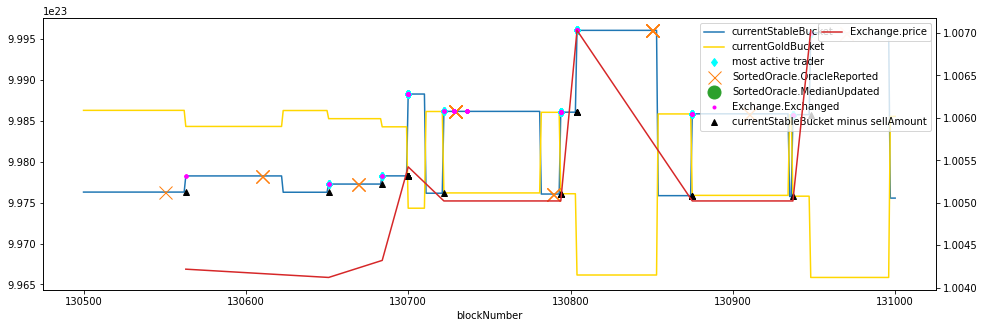

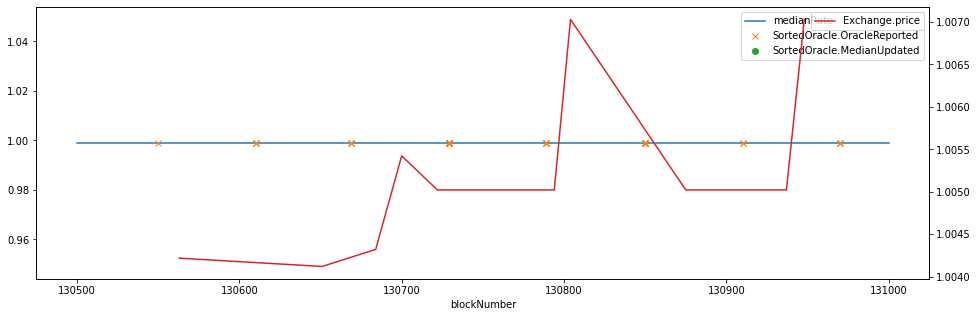

In [23]:
SortedOraclesAddress = '0x91061bF2F509AF76aa01F46E9F3E97577a5a80BA'
OracleReported = '0xdbf09271932e018b9c31e9988e4fbe3109fdd79d78f5d19a764dfb56035ed775'
MedianUpdated = '0x01f3db74cdcb3b158f2144fb78c5ab54e9e8a8c09d3d3b7713050cdb6b6bcb97'
Exchange = '0xC8FD77490A12F46709BffbCC0FCe35740Da8D860'
Exchanged = '0x402ac9185b4616422c2794bf5b118bfcc68ed496d52c0d9841dfa114fdeb05ba'

def filter_event(_df, event, arg='topic'):
    df_event_matches = _df[_df[arg] == event]
    return df_event_matches \
        .merge(df_events, left_on='blockNumber', right_on='blockNumber', suffixes=('_receipt', '')) \
        .merge(df_state, left_on='blockNumber', right_on='blockNumber', suffixes=('', '_state'))

df_report = filter_event(df_receipt, OracleReported)
df_median = filter_event(df_receipt, MedianUpdated)
df_exchanged = filter_event(df_receipt, Exchanged)

df_price = df_buy_sellusd[df_buy_sellusd.index>=window_min]
df_price = df_price[df_price.index<=window_max]
df_price = df_price[df_price.sellamount>0]
price_exchange = df_price.sellamount/df_price.buyamount

df_exchangers = df_exchanged.groupby('from_receipt').count().sort_values(by='blockNumber', ascending=False)
top_exchanger = df_exchangers.index[0] if len(df_exchangers.index) else None

df_active_trader = filter_event(df_receipt, top_exchanger, 'from')
df_active_trader = df_active_trader[df_active_trader.sellamount>0]
fig, ax = plt.subplots()
df_state.set_index('blockNumber').currentStableBucket.plot(ax=ax)
df_state.set_index('blockNumber').currentGoldBucket.plot(ax=ax, marker=".", ms=0, color='gold')
df_active_trader.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker="d", linestyle='None', label="most active trader", color="cyan")
df_report.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker="x", ms=13, linestyle='None', label="SortedOracle.OracleReported")
df_median.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker="o", ms=13, linestyle='None', label="SortedOracle.MedianUpdated")
df_exchanged.set_index('blockNumber').currentStableBucket.plot(ax=ax, marker=".", linestyle='None', label="Exchange.Exchanged", color="magenta")
df_volumes = df_exchanged.set_index('blockNumber')
df_volumes = df_volumes[df_volumes.sellamount>0]
(df_volumes.currentStableBucket - df_volumes.sellamount).plot(ax=ax, marker="^", linestyle='None', color="black", label="currentStableBucket minus sellAmount")
price_exchange.plot(ax=ax, secondary_y=True, label='Exchange.price')
[ax.legend(loc=1) for ax in plt.gcf().axes]

fig, ax = plt.subplots()
df_state.set_index('blockNumber').medianRate.plot(ax=ax)
df_report.set_index('blockNumber').medianRate.plot(ax=ax, marker="x", linestyle='None', label="SortedOracle.OracleReported")
df_median.set_index('blockNumber').medianRate.plot(ax=ax, marker="o", linestyle='None', label="SortedOracle.MedianUpdated")
price_exchange.plot(ax=ax, secondary_y=True, label='Exchange.price')
[ax.legend(loc=1) for ax in plt.gcf().axes]

In [24]:
df_exchangers.head()

,blockNumber,address_receipt,topic,address,eventName,identifier,addr,identifierhash,slasheridentifier,account,...,medianRate_state,currentStableBucket_state,currentGoldBucket_state,goldTokenTotalSupply_state,timestamp_block_state,gasUsed_state,gasLimit_state,txAmount_state,blocktime_state,datetime_block_state
from_receipt,,,,,,,,,,,,,,,,,,,,,
0x8fb800b94d2b1258236e598fcd5e65eaf45ca671,239,239,239,239,239,0,0,0,0,0,...,239,239,239,239,239,239,239,239,239,239
0x73b49da41223585a650712363ba7878ed60a964d,24,24,24,24,24,0,0,0,0,0,...,24,24,24,24,24,24,24,24,24,24
0xd6f05649c5350c20030de1dc57ed31510141f487,16,16,16,16,16,0,0,0,0,0,...,16,16,16,16,16,16,16,16,16,16
0x060b52f506579625ad73b99f1be8d6b06259953d,4,4,4,4,4,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4


blockNumber
130623.0            0.0
130711.0            0.0
130782.0    134217728.0
130854.0   -134217728.0
130935.0            0.0
130997.0   -134217728.0
dtype: float64

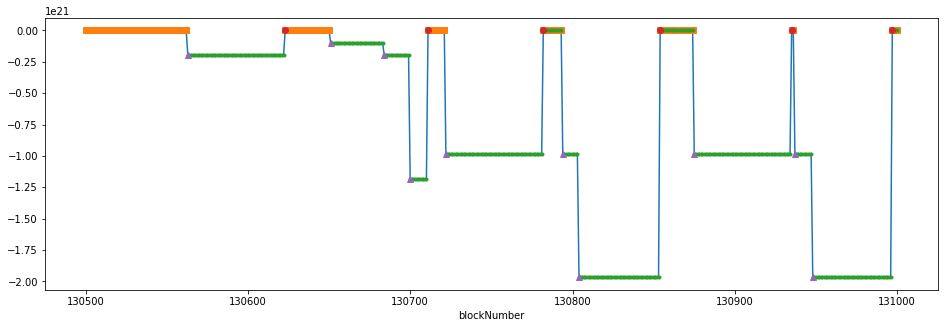

In [25]:
r = df_state.set_index('blockNumber').currentGoldBucket.diff()
exchange_balance = (0.01*(df_balance[df_balance.contract=="GoldToken"].set_index('blockNumber').balance))
bucket_diff = (df_state.set_index('blockNumber').currentGoldBucket - exchange_balance)

fig, ax = plt.subplots()
bucket_diff.plot(ax=ax)
bucket_diff[bucket_diff.abs()<1e10].plot(ax=ax, marker='s', linestyle='None')
bucket_diff[bucket_diff!=0].plot(ax=ax, marker='.', linestyle='None')
bucket_diff[r>0].plot(ax=ax, marker='o', linestyle='None')
bucket_diff[r<0].plot(ax=ax, marker='^', linestyle='None')
bucket_diff[r>0]